In [1]:
# Pipeline Execution Notebook
# Title
# ------
# This Jupyter Notebook demonstrates how to execute a data processing pipeline for astronomical observations.

# Subtitle
# --------
# The pipeline consists of several steps, including rebinning, calibration, subtraction, application of calibration, and imaging.



In [3]:
import time
import logging
import lithops
from radiointerferometry.utils import setup_logging, get_executor_id_lithops
from radiointerferometry.steps.imaging import ImagingStep
from radiointerferometry.steps.pipelinestep import DP3Step
from radiointerferometry.datasource import InputS3, OutputS3
from radiointerferometry.partitioning import StaticPartitioner
from radiointerferometry.profiling import (
    CompletedWorkflow,
    CompletedWorkflowsCollection,
)

# Logger setup
LOG_LEVEL = logging.INFO
logger = setup_logging(LOG_LEVEL)
partitioner = StaticPartitioner(log_level=LOG_LEVEL)


#TODO: Find another way to get the executor id from lithops, this causes errors
def prepend_hash_to_key(key: str) -> str:
    return f"{get_executor_id_lithops()}/{key}"


2024-06-14 16:14:53 [INFO] Started StaticPartitioner


In [5]:


#THIS CODE PREPARES THE INPUTS FOR THE WORKFLOW

fexec = lithops.FunctionExecutor(runtime_memory=2048, runtime_cpu=4)

# Input ms's are stored here
inputs = InputS3(bucket="ayman-extract", key="partitions/partitions_7900_20zip_1/")

# Where to store the output ms's after partitioning
msout = OutputS3(bucket="ayman-extract", key=f"partitions/partitions_total_10zip/")




# The partitioning params are the input ms, the number of partitions, and the output ms.
partitioning_params = {
    "msin": inputs,
    "num_partitions": 10,
    "msout": msout,
}

future = fexec.call_async(partitioner.partition_ms, partitioning_params)

result = fexec.get_result()

logger.info(f"Partitioning result: {result}")

print(type(result))
# Use as input the created partitions
inputs = InputS3(bucket="ayman-extract", key="partitions/partitions_total_10zip/")


2024-06-14 16:17:37,157 - INFO - Lithops v3.3.1.dev0 - Python3.10
2024-06-14 16:17:37,165 - INFO - Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-14 16:17:37,416 - INFO - Kubernetes client created - Namespace: default
2024-06-14 16:17:37,417 - INFO - ExecutorID e88e9d-2 | JobID A000 - Selected Runtime: docker.io/ayman321/extract5 - 2048MB
2024-06-14 16:17:38,403 - INFO - ExecutorID e88e9d-2 | JobID A000 - Starting function invocation: partition_ms() - Total: 1 activations
2024-06-14 16:17:38,796 - INFO - ExecutorID e88e9d-2 | JobID A000 - View execution logs at /tmp/lithops-ayman/logs/e88e9d-2-A000.log
2024-06-14 16:17:38,797 - INFO - ExecutorID e88e9d-2 - Getting results from 1 function activations
2024-06-14 16:17:38,798 - INFO - ExecutorID e88e9d-2 - Waiting for 1 function activations to complete
2024-06-14 16:17:43,804 - WARNING - ExecutorID e88e9d-2 | JobID A000 - CallID: 00000 - There was an exception - Activation ID: 33c35587483b - ClientError
2024-06

ClientError: An error occurred (AccessDenied) when calling the ListObjectsV2 operation: Access Denied.

In [7]:
# Rebinning parameters with hash included in the key as a root directory, notice how we use the result from the partitioning step
rebinning_params = {
    "msin": result,
    "steps": "[aoflag, avg, count]",
    "aoflag.type": "aoflagger",
    "aoflag.strategy": InputS3(
        bucket="ayman-extract",
        key="parameters/rebinning/STEP1-NenuFAR64C1S.lua",
    ),
    "avg.type": "averager",
    "avg.freqstep": 4,
    "avg.timestep": 8,
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "numthreads": 4,
    "log_output": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("rebinning_out/logs"),
        file_ext="log",
    ),
}


# Calibration parameters with hash included in the key as a root directory
calibration_params = {
    "msin": InputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
    ),
    "msin.datacolumn": "DATA",
    "msout": ".",
    "steps": "[cal]",
    "cal.type": "ddecal",
    "cal.mode": "diagonal",
    "cal.sourcedb": InputS3(
        bucket="ayman-extract",
        key="parameters/calibration/STEP2A-apparent.sourcedb",
    ),
    "cal.h5parm": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/cal/h5"),
        file_ext="h5",
    ),
    "cal.solint": 4,
    "cal.nchan": 4,
    "cal.maxiter": 50,
    "cal.uvlambdamin": 5,
    "cal.smoothnessconstraint": 2e6,
    "numthreads": 4,
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "log_output": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/cal/logs"),
        file_ext="log",
    ),
}

# Subtraction parameters with hash included in the key as a root directory
substraction = {
    "msin": InputS3(bucket="ayman-extract", key=prepend_hash_to_key("applycal_out/ms")),
    "msin.datacolumn": "DATA",
    "msout.datacolumn": "SUBTRACTED_DATA",
    "steps": "[sub]",
    "sub.type": "h5parmpredict",
    "sub.sourcedb": InputS3(
        bucket="ayman-extract",
        key="parameters/calibration/STEP2A-apparent.sourcedb",
    ),
    "sub.directions": "[[CygA],[CasA]]",
    "sub.operation": "subtract",
    "sub.applycal.parmdb": InputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/cal/h5"),
        dynamic=True,
        file_ext="h5",
    ),
    "sub.applycal.steps": "[sub_apply_amp,sub_apply_phase]",
    "sub.applycal.correction": "fulljones",
    "sub.applycal.sub_apply_amp.correction": "amplitude000",
    "sub.applycal.sub_apply_phase.correction": "phase000",
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "log_output": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/substract/logs"),
        file_ext="log",
    ),
}

# Apply calibration parameters with hash included in the key as a root directory
apply_calibration = {
    "msin": InputS3(bucket="ayman-extract", key=prepend_hash_to_key("applycal_out/ms")),
    "msin.datacolumn": "SUBTRACTED_DATA",
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "msout.datacolumn": "CORRECTED_DATA",
    "steps": "[apply]",
    "apply.type": "applycal",
    "apply.steps": "[apply_amp,apply_phase]",
    "apply.apply_amp.correction": "amplitude000",
    "apply.apply_phase.correction": "phase000",
    "apply.direction": "[Main]",
    "apply.parmdb": InputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/cal/h5"),
        dynamic=True,
        file_ext="h5",
    ),
    "log_output": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/apply/logs"),
        file_ext="log",
    ),
}

# Imaging parameters with hash included in the key as a root directory
imaging_params = [
    "-size",
    "1024",
    "1024",
    "-pol",
    "I",
    "-scale",
    "5arcmin",
    "-niter",
    "100000",
    "-gain",
    "0.1",
    "-mgain",
    "0.6",
    "-auto-mask",
    "5",
    "-local-rms",
    "-multiscale",
    "-no-update-model-required",
    "-make-psf",
    "-auto-threshold",
    "3",
    "-weight",
    "briggs",
    "0",
    "-data-column",
    "CORRECTED_DATA",
    "-nmiter",
    "0",
    "-name",
    OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("imag_out"),
    ),
]

NameError: name 'result' is not defined

In [9]:
# Execute Rebinning
# Execute Rebinning
start_time = time.time()
rebinning_runner = DP3Step(parameters=rebinning_params, log_level=LOG_LEVEL)

completed_step = rebinning_runner(step_name="rebinning", func_limit=1)

end_time = time.time()

logger.info(f"Rebinning completed in {end_time - start_time} seconds.")

2024-05-22 14:58:45,545 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10
2024-05-22 14:58:45,558 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 14:58:45,588 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-05-22 14:58:45,601 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 14:58:45 [INFO] keys : ['partitions/partitions_total_10zip/1a02f28fcfaf259c2141ce26248396ff/partition_0.ms.zip']
2024-05-22 14:58:45,631 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 14:58:45 [INFO] New output path: cd81b6/applycal_out/ms/partition_0.ms
2024-05-22 14:58:45 [INFO] New output path: cd81b6/rebinning_out/logs/partition_0.log
2024-05-22 14:58:45 [INFO] Function params: [[{'msin': /ayman-extract/partitions/partitions_total_10zip/1a02f28fcfaf259c2141ce26248396ff/partition_0.ms.zip, 'steps': '[aoflag, avg, count]', 'aoflag.type': 'aoflagger', 'aoflag.st

In [10]:
# Execute Calibration
start_time = time.time()
finished_job = DP3Step(
    parameters=[calibration_params, substraction, apply_calibration],
    log_level=LOG_LEVEL,
).run()
end_time = time.time()
logger.info(f"Calibration completed in {end_time - start_time} seconds.")


2024-05-22 15:00:15,087 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10
2024-05-22 15:00:15,100 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 15:00:15,130 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-05-22 15:00:15,143 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 15:00:15 [INFO] keys : ['cd81b6/applycal_out/ms/partition_0.ms.zip']
2024-05-22 15:00:15,168 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 15:00:15 [INFO] New output path: cd81b6/applycal_out/ms/partition_0.ms
2024-05-22 15:00:15 [INFO] New output path: cd81b6/applycal_out/cal/h5/partition_0.h5
2024-05-22 15:00:15 [INFO] New output path: cd81b6/applycal_out/cal/logs/partition_0.log
2024-05-22 15:00:15 [INFO] New output path: cd81b6/applycal_out/ms/partition_0.ms
2024-05-22 15:00:15 [INFO] New output path: cd81b6/applycal_out/substract/logs/partition_0.log
2024-0

In [11]:
# Execute Imaging
start_time = time.time()
finished_job = ImagingStep(
    input_data_path=InputS3(
        bucket="ayman-extract", key=prepend_hash_to_key("applycal_out/ms")
    ),
    parameters=imaging_params,
    log_level=LOG_LEVEL,
).run()
end_time = time.time()
logger.info(f"Imaging completed in {end_time - start_time} seconds.")

2024-05-22 15:03:37,270 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10
2024-05-22 15:03:37,291 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 15:03:37,331 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-05-22 15:03:37,348 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 15:03:37,375 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-05-22 15:03:37,387 [INFO] invokers.py:107 -- ExecutorID cd81b6-5 | JobID A000 - Selected Runtime: docker.io/ayman321/extract3 - 2000MB
2024-05-22 15:03:38,128 [INFO] invokers.py:172 -- ExecutorID cd81b6-5 | JobID A000 - Starting function invocation: _execute_step() - Total: 1 activations
2024-05-22 15:03:38,258 [INFO] invokers.py:208 -- ExecutorID cd81b6-5 | JobID A000 - View execution logs at /tmp/lithops-ayman/logs/cd81b6-5-A000.log
2024-05-22 15:03:38 [INFO] imaging.py:172 -- parameters: ['-size', '1024', '

In [3]:
import lithops



# fits image is stored at:
bucket = 'os-10gb'
key = '5592df/imag_out-image.fits'



# Download the file from the storage backend
lithops.Storage().download_file(bucket, key, './image-CORRECTED_DATA.fits')


True

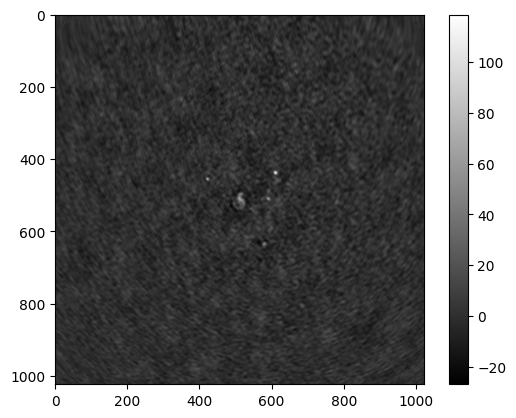

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Specify the path to the .fits file
fits_file_path = './imag_out-image10.fits'

# Open the .fits file
image_data = fits.getdata(fits_file_path)

# Adjust the image_data to reduce its dimensionality to 2D
image_data_2d = image_data[0, 0, :, :]

# Now use plt.imshow on the 2D image data
plt.imshow(image_data_2d, cmap='gray')
plt.colorbar()
plt.show()








